In [1]:
import os
import itertools
import pathos
import functools
from functools import partial
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.feature_selection import mutual_info_regression as MI

import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append('/home/leonardo/git/bayesian_bss')
from src import MAPGradientEstimator, InstantaneousMixtureModel

np.random.seed(2000)

# ENSAIO - COMPORTAMENTO ASSINTÓTICO MLE

#### Objetivos:
#### - Verificar o efeito do tamanho das observações sobre o erro de estimação dos coeficientes da matriz de separação.

# Função a ser otimizada (probabilidade a posteriori)

#### De Djafari, 2000, a probabilidade a posteriori:
$$ \log P(\boldsymbol{B}|y) = T \log |det({B})| + \sum_{t} \sum_{i} \log p_{i}(y_{i}(t)) + \log P(\boldsymbol{B}) + cte$$

#### Considerando a distribuição a priori uma constante, tem-se a verossimilhança:
$$ \log P(y|\boldsymbol{B}) = T \log |det({B})| + \sum_{t} \sum_{i} \log p_{i}(y_{i}(t)) + cte$$

# 1. PERFECT MODEL

## 1.1. Initialize Sources

In [2]:
def source_cumulative(x):
    return 1/(1+np.exp(-x))

def source_pdf(x):
    return np.exp(-x)/np.square(1+np.exp(-x))

def source_generator(
    nsources,
    obs_len,
    nobs,
    mu
):
    return np.random.logistic(
        loc=mu,
        scale=1,
        size=(nsources, obs_len, nobs)
    )

def prior_pdf(B):
    return 1

def get_posteriori_neighborhood(
    A,
    x,
    T,
    u_vec,
    v_vec,
    n_points,
    source_pdf_fn,
    prior_pdf_fn,
    njobs=1
):
    
    def __get_posteriori(
        A,
        x,
        T,
        source_pdf_fn,
        prior_pdf_fn,
        idx_info
    ):
        i, u = idx_info[0]
        j, v = idx_info[-1]
        
        # A_shifted = A + u*symmetric_basis + v*skew_symmetric_basis
        
        # B = np.linalg.inv(A_shifted)
        
        B = np.linalg.inv(A) + u*symmetric_basis + v*skew_symmetric_basis
        
        likelihood = np.log(np.abs(np.linalg.det(B)))
        
        likelihood_iterator = [
            (t,i) for t,i in itertools.product(
                range(x.shape[-1]),
                range(x.shape[0]))
        ]

        s_est = B@x

        likelihood += (1/T)*np.sum([
            np.log(source_pdf_fn(s_est[i,t])) for t,i in likelihood_iterator
        ])
        
        prior = np.log(prior_pdf_fn(B))/T
        
        return {
            'i': i,
            'j': j,
            'log_posteriori': likelihood + prior
        }
        

    symmetric_basis = np.array([
        [0, 1],
        [1, 0]
    ])

    skew_symmetric_basis = np.array([
        [0, -1],
        [1, 0]
    ])
    
    iterator = itertools.product(
        enumerate(u_vec),
        enumerate(v_vec)
    )
    # it = [x for x in iterator]
    
    exec_fn = partial(
        __get_posteriori,
        A,
        x,
        T,
        source_pdf_fn,
        prior_pdf_fn
    )
    
    z = np.empty(
        shape=(
            u_vec.shape[0],
            v_vec.shape[0]
        )
    )
    with pathos.multiprocessing.ProcessingPool(njobs) as p:
        results = p.map(exec_fn, iterator)
    
    for r in results:
        i=r['i']
        j=r['j']
        z[i, j]=r['log_posteriori']
    
    return z

In [3]:
# Number of sources, length of observations and number of obserfations
NSOURCES=2
OBSLEN=[
    10,
    50,
    100,
    500,
    1000,
    5000,
    10000
]
NOBS=500
MU=0.0

# Mixing matrix
A = np.array([
    [1, 1],
    [-0.5, 0.5]
])

u_lims = (-0.1, 0.1)
v_lims = (-0.1, 0.1)
n_points = 101
central_point = [0, 0]

# Get step
u_step = (u_lims[-1] - u_lims[0])/(n_points-1)
v_step = (v_lims[-1] - v_lims[0])/(n_points-1)

# Step multipliers
step_multipliers = range(-(n_points-1)//2, (n_points-1)//2)

# Get u_vec and v_vec
u_vec = np.array([central_point[0] + s*u_step for s in step_multipliers])
v_vec = np.array([central_point[-1] + s*v_step for s in step_multipliers])



In [4]:
%%time


estimations = {str(l): [] for l in OBSLEN}
estimations_post = {str(l): [] for l in OBSLEN}
for l in tqdm(OBSLEN):
    # Generate observations
    s = source_generator(
        nsources=NSOURCES,
        obs_len=l,
        nobs=NOBS,
        mu=MU
    )
    for i in range(NOBS):
        
        s_i=s[:, :, i]
        x_i=A@s_i
        
        z = get_posteriori_neighborhood(
            A=A,
            x=x_i,
            T=l,
            u_vec=u_vec,
            v_vec=v_vec,
            n_points=n_points,
            source_pdf_fn=source_pdf,
            prior_pdf_fn=prior_pdf,
            njobs=os.cpu_count()-1
        )
        
        # Ponto de máximo
        max_post_point = np.unravel_index(
            z.argmax(), 
            z.shape
        )
        estimations[str(l)].append(max_post_point)

        # Maxima posteriori
        max_post = z[max_post_point]
        estimations_post[str(l)].append(max_post)


100%|██████████████████████████████████████████████████████████████████████████| 7/7 [45:16:35<00:00, 23285.05s/it]

CPU times: user 38min 31s, sys: 1min 7s, total: 39min 38s
Wall time: 1d 21h 16min 35s


In [5]:
symmetric_basis = np.array([
    [0, 1],
    [1, 0]
])

skew_symmetric_basis = np.array([
    [0, -1],
    [1, 0]
])

results = pd.DataFrame()
for l, maxes in estimations.items():
    for m in maxes:
        B_est = np.linalg.inv(A + u_vec[m[0]]*symmetric_basis + v_vec[m[-1]]*skew_symmetric_basis)
        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    index=[0],
                    data={
                        'T': [l],
                        'u_v': [m],
                        'B_est': [B_est],
                        'MSE': [
                            np.linalg.norm(
                                np.subtract(np.linalg.inv(A), B_est)
                            )
                        ]
                        
                    }
                )
            ]
        )
        
results = results.reset_index(
    drop=True
)
results['T'] = results['T'].astype(int)
results.head()

,T,u_v,B_est,MSE
0,10,"(0, 99)","[[0.5539527854961865, -0.8885402679358835], [0...",0.173588
1,10,"(21, 99)","[[0.562910924975232, -0.9501936413581914], [0....",0.150297
2,10,"(99, 0)","[[0.4539693262005673, -1.0877105055765592], [0...",0.142275
3,10,"(0, 99)","[[0.5539527854961865, -0.8885402679358835], [0...",0.173588
4,10,"(0, 82)","[[0.5273727555015525, -0.881767247198596], [0....",0.148307


In [13]:
results.rename(columns={'T':'N'})

,N,u_v,B_est,MSE,err,err_00,err_10,err_01,err_11
0,10,"(0, 99)","[[0.5539527854961865, -0.8885402679358835], [0...",0.173588,"[[0.05395278549618654, 0.11145973206411652], [...",0.053953,0.056169,0.111460,0.107906
1,10,"(21, 99)","[[0.562910924975232, -0.9501936413581914], [0....",0.150297,"[[0.06291092497523199, 0.0498063586418086], [0...",0.062911,0.017878,0.049806,0.125822
2,10,"(99, 0)","[[0.4539693262005673, -1.0877105055765592], [0...",0.142275,"[[-0.04603067379943271, -0.08771050557655924],...",-0.046031,-0.044215,-0.087711,-0.092061
3,10,"(0, 99)","[[0.5539527854961865, -0.8885402679358835], [0...",0.173588,"[[0.05395278549618654, 0.11145973206411652], [...",0.053953,0.056169,0.111460,0.107906
4,10,"(0, 82)","[[0.5273727555015525, -0.881767247198596], [0....",0.148307,"[[0.027372755501552493, 0.118232752801404], [0...",0.027373,0.065344,0.118233,0.054746
...,...,...,...,...,...,...,...,...,...
3495,10000,"(46, 65)","[[0.5209223242303893, -1.0022545518192691], [0...",0.046881,"[[0.02092232423038931, -0.002254551819269146],...",0.020922,-0.001998,-0.002255,0.041845
3496,10000,"(56, 45)","[[0.49556174897616934, -1.0129282149072905], [...",0.017517,"[[-0.004438251023830664, -0.012928214907290458...",-0.004438,-0.006420,-0.012928,-0.008877
3497,10000,"(48, 56)","[[0.5080639916758796, -0.999869935618131], [0....",0.018032,"[[0.008063991675879567, 0.0001300643818690217]...",0.008064,-0.000065,0.000130,0.016128
3498,10000,"(51, 43)","[[0.4901038235939901, -0.9958909695429881], [0...",0.022584,"[[-0.009896176406009927, 0.004109030457011942]...",-0.009896,0.001866,0.004109,-0.019792


,N,MSE
0,10,0.213986
1,50,0.147118
2,100,0.121366
3,500,0.061502
4,1000,0.042869
5,5000,0.019336
6,10000,0.013549


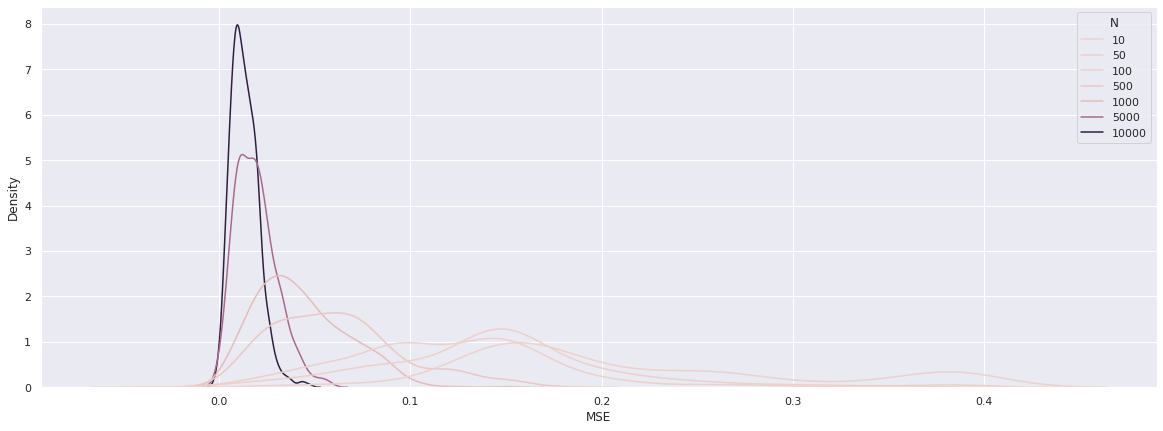

In [15]:
fig = plt.figure(figsize=(20,7))

sns.kdeplot(
    data=results.rename(columns={'T':'N'}),
    x='MSE',
    hue='N'
)

# plt.title(
#     'MSE distribution with variable sample size. $MSE=||\hat{B}-B_{true}||^{2}$',
#     fontsize=20
# )

results.rename(columns={'T':'N'}).groupby(
    by='N',
    as_index=False
).agg({
    'MSE':'mean'
}).sort_values(
    by='N'
).reset_index(
    drop=True
)

In [7]:
# Get coefficient errors
results['err'] = results['B_est'].apply(
    lambda B_hat: np.subtract(B_hat, np.linalg.inv(A))
)
results['err_00'] = results['err'].apply(
    lambda e: e[0,0]
)
results['err_10'] = results['err'].apply(
    lambda e: e[1,0]
)
results['err_01'] = results['err'].apply(
    lambda e: e[0,1]
)
results['err_11'] = results['err'].apply(
    lambda e: e[1,1]
)

,T,err_00
0,10,0.071358
1,50,0.053972
2,100,0.046616
3,500,0.026725
4,1000,0.018146
5,5000,0.008304
6,10000,0.005675


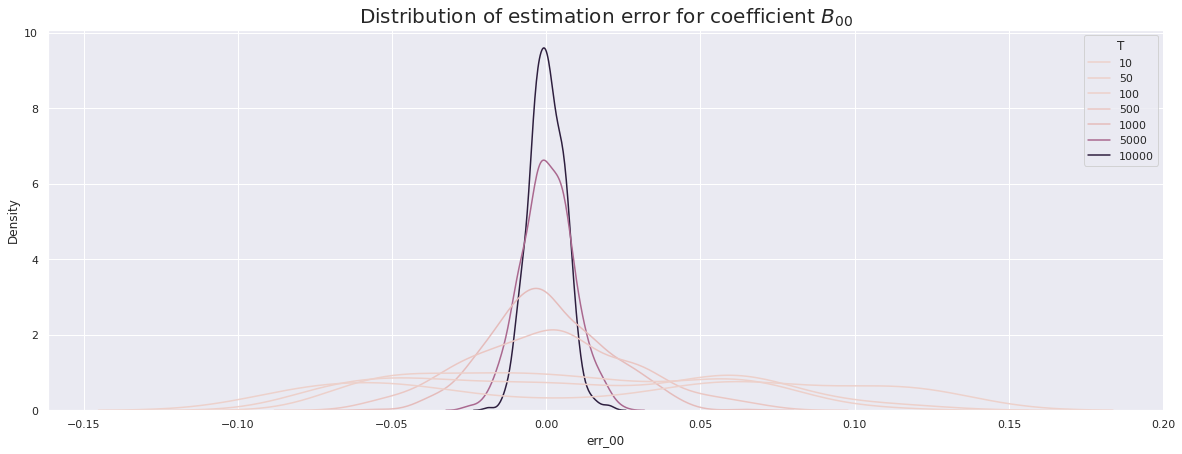

In [8]:
fig = plt.figure(figsize=(20,7))
sns.kdeplot(
    data=results,
    x='err_00',
    hue='T'
)
plt.title(
    'Distribution of estimation error for coefficient $B_{00}$',
    fontsize=20
)
results.groupby(
    'T',
    as_index=False
).agg({
    'err_00': lambda x:np.mean(x),
    'err_00': lambda x:np.std(x)
})

Text(0.5, 1.0, 'Distribution of estimation error for coefficient $B_{10}$')

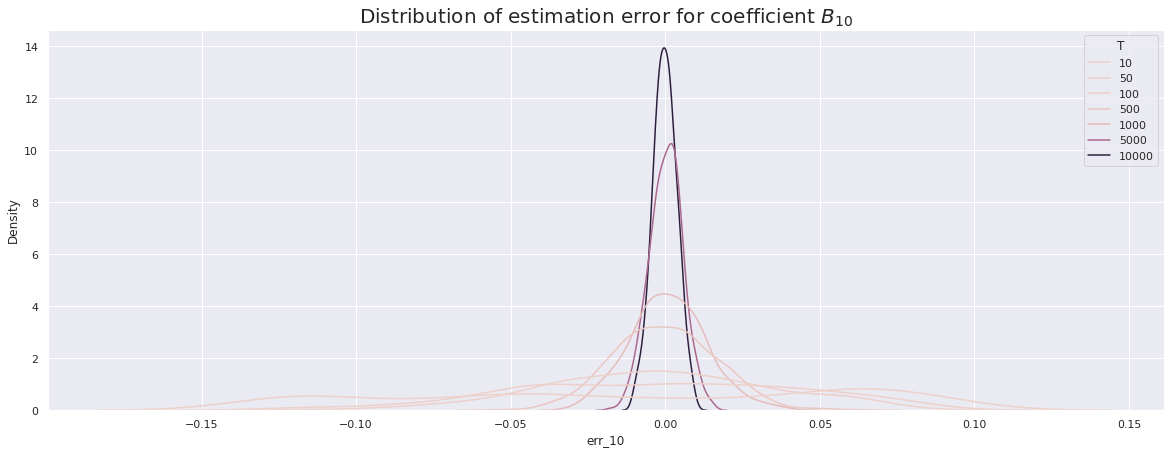

In [9]:
fig = plt.figure(figsize=(20,7))
sns.kdeplot(
    data=results,
    x='err_10',
    hue='T'
)
plt.title(
    'Distribution of estimation error for coefficient $B_{10}$',
    fontsize=20
)

Text(0.5, 1.0, 'Distribution of estimation error for coefficient $B_{01}$')

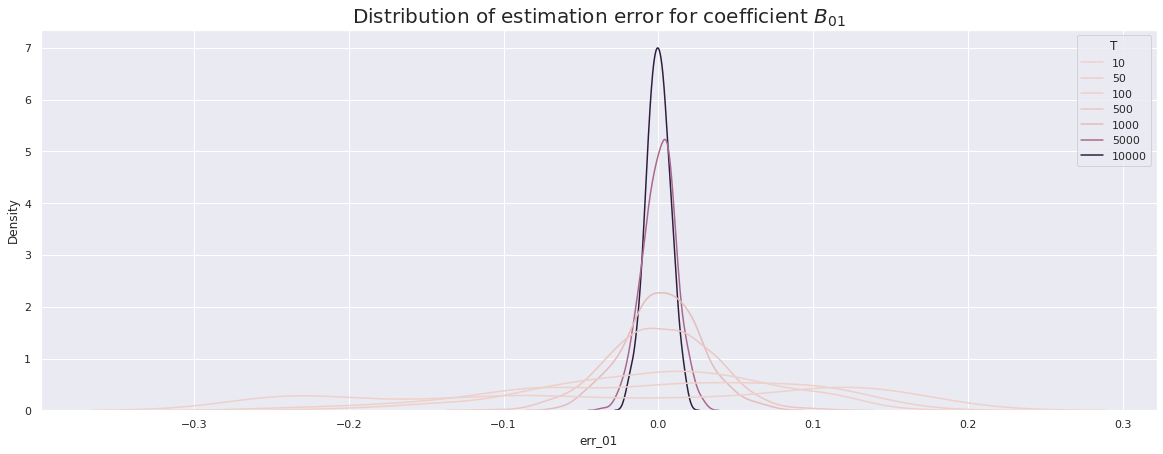

In [10]:
fig = plt.figure(figsize=(20,7))
sns.kdeplot(
    data=results,
    x='err_01',
    hue='T'
)
plt.title(
    'Distribution of estimation error for coefficient $B_{01}$',
    fontsize=20
)

Text(0.5, 1.0, 'Distribution of estimation error for coefficient $B_{11}$')

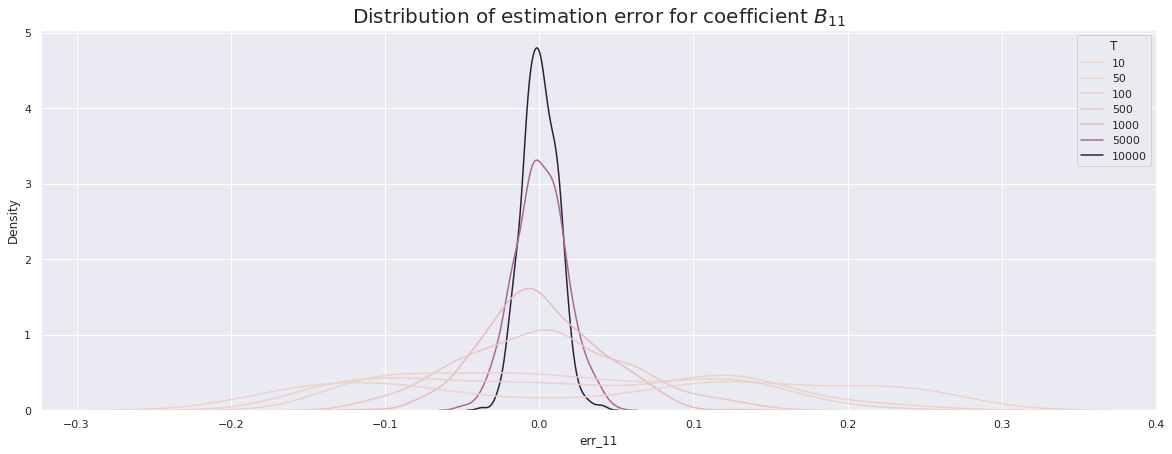

In [11]:
fig = plt.figure(figsize=(20,7))
sns.kdeplot(
    data=results,
    x='err_11',
    hue='T'
)
plt.title(
    'Distribution of estimation error for coefficient $B_{11}$',
    fontsize=20
)